# Subduction obliquity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
%matplotlib inline

import pygplates
import ptt



# Input rotation and topology files.
rotation_filename = '../data/Global_EarthByte_230-0Ma_GK07_AREPS.rot'
rotation_model = pygplates.RotationModel(rotation_filename)
topology_filenames = [
        '../data/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpmlz',
        '../data/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpmlz']

topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    topology_features.add(pygplates.FeatureCollection(topology_filename))


coastlines = "../data/Matthews_etal_GPC_2016_Coastlines.gpmlz"

# Tessellate the subduction zones to 0.5 degrees.
tessellation_threshold_radians = np.radians(0.5)

In [2]:
reconstruction_time = 0

# calculate subduction convergence
subduction_data = ptt.subduction_convergence.subduction_convergence(
    rotation_model,
    topology_filenames,
    tessellation_threshold_radians,
    reconstruction_time,
    anchor_plate_id=0)
subduction_data = np.vstack(subduction_data)
subduction_lon     = subduction_data[:,0]
subduction_lat     = subduction_data[:,1]
subduction_angle   = subduction_data[:,3]
subduction_normal  = subduction_data[:,7]
subduction_length  = np.radians(subduction_data[:,6]) * pygplates.Earth.mean_radius_in_kms * 1e3 # in metres

# protect against "negative" subduction
subduction_data[:,2] = np.clip(subduction_data[:,2], 0.0, 1e99)
subduction_convergence = np.fabs(subduction_data[:,2])*1e-2 * np.cos(np.radians(subduction_data[:,3]))

/home/ben/.local/lib/python3.7/site-packages/ptt/subduction_convergence.py:362: RuntimeWarning: Unable to find the subducting plate of the subducting sub-segment "Aleutian and Bering Sea Masking Polygon" at 0.0Ma.
    Either the subduction polarity is not properly set or there is not exactly one subducting plate sharing the sub-segment.
    Ignoring current sub-segment.
  RuntimeWarning)
/home/ben/.local/lib/python3.7/site-packages/ptt/subduction_convergence.py:362: RuntimeWarning: Unable to find the subducting plate of the subducting sub-segment "Kalimantan subduction boundary (inferred)" at 0.0Ma.
    Either the subduction polarity is not properly set or there is not exactly one subducting plate sharing the sub-segment.
    Ignoring current sub-segment.
  RuntimeWarning)
/home/ben/.local/lib/python3.7/site-packages/ptt/subduction_convergence.py:362: RuntimeWarning: Unable to find the subducting plate of the subducting sub-segment "Hikurangi& Kermadec TR" at 0.0Ma.
    Either the subd

In [3]:
# reconstruct coastlines
output_reconstruction = 'coastlines.shp'
pygplates.reconstruct(coastlines, rotation_model, output_reconstruction, reconstruction_time)

# read in shapefile
shp_coast = shpreader.Reader(output_reconstruction).geometries()
ft_coast  = cfeature.ShapelyFeature(shp_coast, crs=ccrs.PlateCarree(), facecolor='LightGrey', edgecolor='k')

In [4]:
# get plate velocity
Xnodes, Ynodes, U, V = ptt.velocity_tools.get_velocity_x_y_u_v(reconstruction_time, rotation_model,
                                                               topology_features)

/home/ben/.local/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/ben/.local/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in subtract
  u, v = self.projection.transform_vectors(t, x, y, u, v)


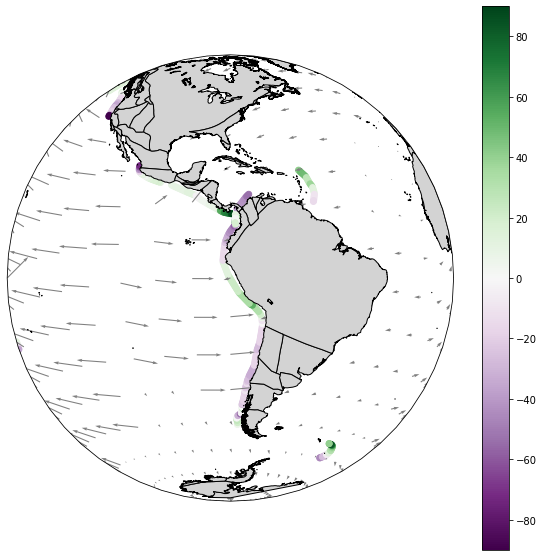

In [5]:
proj = ccrs.Orthographic(-80, -10)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, projection=proj)
ax1.set_global()
ax1.add_feature(ft_coast)
sc1 = ax1.scatter(subduction_lon, subduction_lat,
                  c=subduction_angle,
                  cmap='PRGn', vmin=-90, vmax=90,
                  transform=ccrs.PlateCarree())

ax1.quiver(Xnodes, Ynodes, U, V, color='0.5', transform=ccrs.PlateCarree())
fig.colorbar(sc1, ax=ax1)

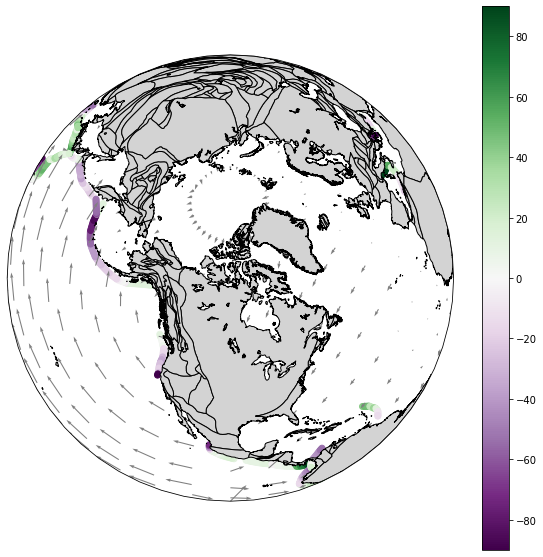

In [6]:
proj = ccrs.Orthographic(-100, 70)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, projection=proj)
ax1.set_global()
ax1.add_feature(ft_coast)
sc1 = ax1.scatter(subduction_lon, subduction_lat,
                  c=subduction_angle,
                  cmap='PRGn', vmin=-90, vmax=90,
                  transform=ccrs.PlateCarree())

ax1.quiver(Xnodes, Ynodes, U, V, color='0.5', transform=ccrs.PlateCarree())
fig.colorbar(sc1, ax=ax1)